### Cohortify Example

This notebook demonstrates how and when to use the `cohortify` module, which is whenever you have right censored data that can be analyzed in _tranches_ or _cohorts_. 

A cohort is a set of observations grouped in time, for example: the graduating class of 2019 is a distinct cohort from the graduating class of 2018, is a distinct cohort from the graduating class of 2017, etc... Each of these cohorts can be tracked and analyzed overtime, for example: we may be interested in how many graduates from Dublin High School become teachers. To answer that question for the class of 2019  - in the year 2019 - is difficult because a person often needs some higher education to become a teacher, and therefore it would not be until some number of years into the future that we get actual employment data from the class of 2019. Even then, not everybody takes the same path; some people take a gap year to travel while others go into industry first and then teaching later in life. If we were to ask the same question however for the class of 1999 we would already have 20 years of "seasoned" data and our estimates would be much better while for the class of 1940 - probably near perfect - because chances are that if you graduated in 1940 and have not become a teacher by the year 2019... then you probably never will.

Often, it is the emerging cohorts that are of interest to us ...

In [1]:
import random
import numpy as np
import pandas as pd
from datetime import timedelta

### Generate Some Random Visitor Data

First we will generate some random  visitor data. Let's assume that we

In [2]:
def random_poisson(val):
    "Generate random count data from different Poisson distributions"
    if val >= 0.5:
        return np.random.poisson(lam=3.0, size=1)
    elif 0.25 > val > 0.5:
        return np.random.poisson(lam=2.0, size=1)
    else:
        return np.random.poisson(lam=7.0, size=1)
    
def filter_lag(visitor, days, lag_dict, val):
    """Given a visit date and sign up lag, return None if the lag is beyond
    the observable timeframe based on the max date"""
    if val > 0.7:
        return None
    dt = visitor[1]
    lag = dt + timedelta(days=days)
    if days > int(lag_dict[dt].days):
        return None
    else:
        return lag
    
from pandas._libs.tslibs.nattype import NaTType

def timedelta2days(delta) -> int:
    "Convert a pandas"
    if type(delta) is NaTType:
        return None
    else:
        return int(delta.days)

In [3]:
# some range of dates
visit_dt_range = pd.date_range(end = pd.datetime.today(), periods = 52).to_pydatetime().tolist()

# assuming 50 visitors a day...
visitors = list(zip(np.arange(0, 50 * len(visit_dt_range)), visit_dt_range * 50))

# unique ids
ids = pd.DataFrame(visitors,  columns=["id","visit_dt"])["id"].tolist()
visit_dt = pd.DataFrame(visitors,  columns=["id","visit_dt"])["visit_dt"].tolist()

# current date
max_visit_dt = max(visit_dt)

# dict of dates correspionding to valid number of lags
lag_dict = {dt: (max_visit_dt - dt) for dt in visit_dt}

# generate some arbitrary signup dates
signup_dt = [filter_lag(dt, int(random_poisson(random.random())[0]), lag_dict, random.random()) for dt in visitors]

# create visitor df
df = pd.DataFrame(list(zip(ids, visit_dt, signup_dt)), columns = ["id", "visit_dt", "signup_dt"])

# calculate lag between visit and signup
df["lag"] = df["signup_dt"] - df["visit_dt"]

# convert timedelta to int
df["lag"] = df["lag"].apply(lambda x: timedelta2days(x))

# create df containing all lag vals
df_lag = pd.DataFrame([[np.nan, NaTType(), NaTType(), n] for n in range(int(df["lag"].max() + 1))], columns=["id", "visit_dt", "signup_dt", "lag"])

#  make sure df contains all lag vals in lag column
df = pd.concat([df, df_lag], axis=0)

df[:10]

,id,visit_dt,signup_dt,lag
0,0.0,2019-07-12 15:09:15.245827,2019-07-21 15:09:15.245827,9.0
1,1.0,2019-07-13 15:09:15.245827,2019-07-16 15:09:15.245827,3.0
2,2.0,2019-07-14 15:09:15.245827,2019-07-17 15:09:15.245827,3.0
3,3.0,2019-07-15 15:09:15.245827,2019-07-24 15:09:15.245827,9.0
4,4.0,2019-07-16 15:09:15.245827,2019-07-20 15:09:15.245827,4.0
5,5.0,2019-07-17 15:09:15.245827,NaT,NaN
6,6.0,2019-07-18 15:09:15.245827,2019-07-21 15:09:15.245827,3.0
7,7.0,2019-07-19 15:09:15.245827,2019-07-26 15:09:15.245827,7.0
8,8.0,2019-07-20 15:09:15.245827,2019-07-30 15:09:15.245827,10.0
9,9.0,2019-07-21 15:09:15.245827,NaT,NaN


### Create Cohort Table from Visitor Logs

In [4]:
from pandas import  DataFrame

# create cohort table from raw id, conversion date fields
cohort = df.pivot_table(columns="visit_dt", index="lag", values="id", aggfunc="count")

def rollup(cohort: DataFrame, to_lag: int) -> DataFrame:
    "Rollup a cohort to the given  lag value."
    return pd.concat([cohort.loc[:(to_lag -  1)], pd.DataFrame(cohort.loc[to_lag:].sum(), columns=[to_lag]).T], axis=0)


cohort = rollup(cohort, to_lag=14)

# fill empty cells w/ 0 where lag has passed
for dt in cohort.columns:
    lag = lag_dict[dt].days
    cohort[dt] = cohort[dt][: lag].fillna(0.0)
    
cohort

visit_dt,2019-07-12 15:09:15.245827,2019-07-13 15:09:15.245827,2019-07-14 15:09:15.245827,2019-07-15 15:09:15.245827,2019-07-16 15:09:15.245827,2019-07-17 15:09:15.245827,2019-07-18 15:09:15.245827,2019-07-19 15:09:15.245827,2019-07-20 15:09:15.245827,2019-07-21 15:09:15.245827,...,2019-08-23 15:09:15.245827,2019-08-24 15:09:15.245827,2019-08-25 15:09:15.245827,2019-08-26 15:09:15.245827,2019-08-27 15:09:15.245827,2019-08-28 15:09:15.245827,2019-08-29 15:09:15.245827,2019-08-30 15:09:15.245827,2019-08-31 15:09:15.245827,2019-09-01 15:09:15.245827
0.0,4.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0
1.0,5.0,4.0,3.0,3.0,3.0,3.0,2.0,4.0,3.0,3.0,...,5.0,5.0,2.0,1.0,4.0,5.0,5.0,4.0,4.0,NaN
2.0,4.0,4.0,4.0,2.0,6.0,6.0,5.0,2.0,1.0,6.0,...,2.0,7.0,2.0,7.0,3.0,3.0,3.0,2.0,NaN,NaN
3.0,5.0,5.0,7.0,5.0,8.0,2.0,8.0,3.0,5.0,4.0,...,4.0,1.0,5.0,5.0,3.0,7.0,5.0,NaN,NaN,NaN
4.0,2.0,6.0,3.0,5.0,3.0,4.0,8.0,4.0,6.0,4.0,...,7.0,9.0,2.0,4.0,3.0,4.0,NaN,NaN,NaN,NaN
5.0,7.0,4.0,3.0,6.0,6.0,3.0,5.0,3.0,4.0,4.0,...,6.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN
6.0,2.0,7.0,6.0,4.0,1.0,1.0,2.0,7.0,5.0,6.0,...,5.0,5.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
7.0,3.0,3.0,2.0,5.0,4.0,3.0,1.0,4.0,1.0,1.0,...,3.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8.0,2.0,2.0,1.0,5.0,3.0,4.0,3.0,0.0,1.0,3.0,...,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.0,3.0,2.0,1.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# lag 0
lag_0 = cohort.loc[0].values

# signup rate for lag_0 (e.g. visitors who signup on the same day as their first visit)
print(lag_0)
np.mean(lag_0), np.var(lag_0)

[4. 1. 1. 1. 1. 0. 2. 1. 0. 2. 0. 0. 1. 3. 0. 1. 0. 1. 0. 1. 1. 2. 1. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 4. 1. 0. 1. 0. 0. 1. 1. 2. 0. 0. 1. 1. 1. 0.
 1. 0. 1. 2.]


(0.8269230769230769, 0.9123520710059171)

In [6]:
# lag 1
lag_1 = cohort.loc[1].dropna().values

# signup rate for lag_0 (e.g. visitors who signup on the same day as their first visit)
print(lag_1)
np.mean(lag_1), np.var(lag_1)

[5. 4. 3. 3. 3. 3. 2. 4. 3. 3. 9. 1. 4. 1. 1. 0. 3. 4. 1. 1. 0. 3. 2. 4.
 1. 1. 4. 2. 5. 5. 1. 4. 4. 2. 3. 3. 3. 2. 0. 1. 2. 6. 5. 5. 2. 1. 4. 5.
 5. 4. 4.]


(2.9607843137254903, 3.0965013456362933)

### Populate the Lower Triangle

Starting w/ the most recent date, let's look at how we can model just the `day 1 lag`.

In [7]:
# given a set of tuples (X, y) -  predict y given X

import numpy as np
from sklearn.linear_model import LinearRegression
from pandas import DataFrame

def train_a_lag_model(cohort: DataFrame, lag: int):
    """Given a df of visitor logs, a cohort table of conversion tranches,...
    """
    n_range = list(range(lag + 1))
    arr = pd.DataFrame(np.array([cohort.loc[n].values for n in n_range]).T).dropna().values
    X = arr[:,: lag]
    y = arr[:, lag]
    return LinearRegression().fit(X, y)

### Train a Model

The objective is to define a method that takes a Cohort table and overlays a forecast on top of it, e.g. populate the lower triangle.

In [8]:
lm_dict = {}

for n in range (1, len(cohort.index)):
    lm_dict[n] = train_a_lag_model(cohort, lag=n)

So we now have a model for each lag.

In [9]:
print("models weights:")

for n in range (1, len(cohort.index)):
    reg = lm_dict[n]
    print("lag:", n)
    print(reg.coef_)
    print(reg.intercept_)

models weights:
lag: 1
[-0.13884157]
3.0724020442930153
lag: 2
[ 0.15801879 -0.32289935]
5.26290905642273
lag: 3
[ 0.06454963  0.00766421 -0.14676482]
5.338985586747661
lag: 4
[-0.66491756  0.02022884 -0.03486184 -0.38086912]
6.7613205303864135
lag: 5
[-0.03319736  0.03924959 -0.28375982  0.26224197  0.04749083]
3.642616801731522
lag: 6
[-0.25418201  0.22427817 -0.07579969  0.12183516 -0.09941149 -0.28843247]
4.884182885182106
lag: 7
[-0.00056222 -0.22415256 -0.08390557 -0.15722836 -0.16896468 -0.18347521
 -0.20241481]
7.195447470721449
lag: 8
[ 0.05187916  0.0252388   0.11466154 -0.12958002 -0.01716341 -0.07170772
 -0.28591056 -0.21185887]
4.643533970070589
lag: 9
[ 0.124415   -0.17171007  0.01334941 -0.10945284  0.09775702  0.06823602
 -0.16832199 -0.2108782  -0.09427768]
3.4230366320916357
lag: 10
[ 0.03294356 -0.20791677 -0.41822629 -0.18136981 -0.12726404 -0.03177968
  0.05328243 -0.25685482 -0.15464245 -0.070923  ]
6.398484873479582
lag: 11
[ 0.00642871  0.04069368  0.00928674 -0

What this model is doing is looking within a "cohort" and using the observed values thus far to predict the next "run out" value. So if we are in a cohort with observed runout from t_0 through t_3 it uses [t0, t1, t2, t3] as the covariates to predict t_4.

In [10]:
# array where null

arr = pd.DataFrame(np.array([cohort.loc[n].values for n in range(len(cohort.index))]).T).values
print("cohort array:")
print(arr[-10:])

# get indices we need to predict for
nan_index = np.argwhere(np.isnan(arr))

# sort indices by prediction order
nan_index = nan_index[np.lexsort((nan_index[:, 1], -nan_index[:, 0]))]
print("ordered indices to update:")
print(nan_index[:10])

for i in range (0, len(nan_index)):
    # get array index of first val
    row, col = nan_index[i]

    # get model
    lm = lm_dict[col]

    # get model features
    x = arr[row, :col].reshape(1, -1)

    # predict
    y_hat = lm.predict(np.array(x))[0]

    # update array
    arr[row, col] = int(round(y_hat, 0))

cohort array:
[[ 0.  5.  2.  4.  7.  6.  5.  3.  2.  2. nan nan nan nan nan]
 [ 0.  5.  7.  1.  9.  2.  5.  4.  4. nan nan nan nan nan nan]
 [ 1.  2.  2.  5.  2.  3.  4.  3. nan nan nan nan nan nan nan]
 [ 1.  1.  7.  5.  4.  5.  3. nan nan nan nan nan nan nan nan]
 [ 1.  4.  3.  3.  3.  3. nan nan nan nan nan nan nan nan nan]
 [ 0.  5.  3.  7.  4. nan nan nan nan nan nan nan nan nan nan]
 [ 1.  5.  3.  5. nan nan nan nan nan nan nan nan nan nan nan]
 [ 0.  4.  2. nan nan nan nan nan nan nan nan nan nan nan nan]
 [ 1.  4. nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [ 2. nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]
ordered indices to update:
[[51  1]
 [51  2]
 [51  3]
 [51  4]
 [51  5]
 [51  6]
 [51  7]
 [51  8]
 [51  9]
 [51 10]]


In [11]:
visitors = pd.DataFrame(df.groupby("visit_dt").apply(len), columns=["visitors"])
signups_expected = pd.DataFrame(pd.DataFrame(arr.T, index=cohort.index, columns=cohort.columns).sum(), columns=["signups_expected"])
signups_observed = pd.DataFrame(cohort.sum(), columns=["signups_observed"])

runout_df = visitors.join(signups_observed.join(signups_expected))
runout_df["signups_runout"] = runout_df["signups_expected"] - runout_df["signups_observed"]
runout_df["signups_observed_rate"] = runout_df["signups_observed"] / runout_df["visitors"]
runout_df["signups_expected_rate"] = runout_df["signups_expected"] / runout_df["visitors"]

runout_df.tail()

,visitors,signups_observed,signups_expected,signups_runout,signups_observed_rate,signups_expected_rate
visit_dt,,,,,,
2019-08-28 15:09:15.245827,50,19.0,37.0,18.0,0.38,0.74
2019-08-29 15:09:15.245827,50,14.0,36.0,22.0,0.28,0.72
2019-08-30 15:09:15.245827,50,6.0,35.0,29.0,0.12,0.70
2019-08-31 15:09:15.245827,50,5.0,35.0,30.0,0.10,0.70
2019-09-01 15:09:15.245827,50,2.0,36.0,34.0,0.04,0.72


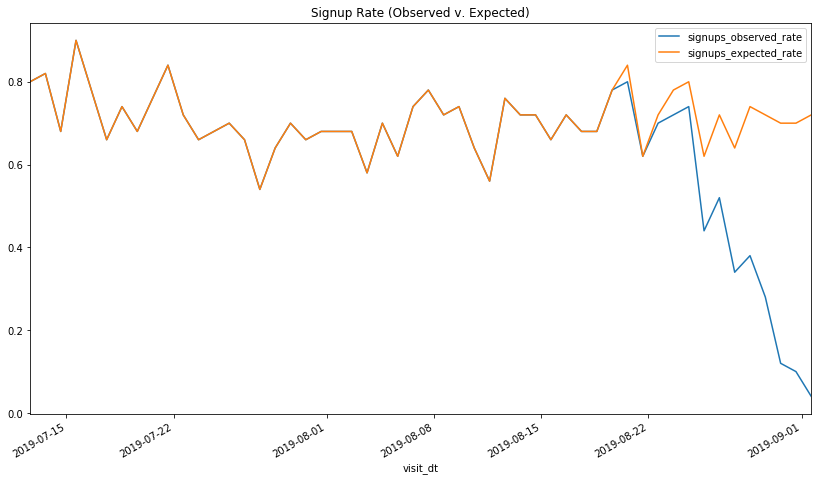

In [13]:
import matplotlib as plt

runout_df[["signups_observed_rate", "signups_expected_rate"]].plot(title="Signup Rate (Observed v. Expected)", figsize=(14, 8));